Running PyTorch on MPS requires MacOS 12.3+ *and* the ARM version of Python installed. We can check the MacOS version with:

In [1]:
import platform; platform.mac_ver()

('10.16', ('', '', ''), 'x86_64')

The first item tells us our MacOS version, this must be greater than *12.3* and if it is not then update your Mac!

The final item tells us the OS version our current environment is running in, this should be *arm64*. An alternative check is to print the `platform`:

In [2]:
platform.platform()

'macOS-10.16-x86_64-i386-64bit'

If the above displays something like `macOS-12.4-x86_64-i386-64bit` (eg containing `x86`), we have the wrong version of Python installed and must install the correct (ARM) version. If using Anaconda a new ARM environment can be set up like so:

```bash
CONDA_SUBDIR=osx-arm64 conda create -n ml python=3.9 -c conda-forge
```

Here we are setting the conda version variable to use ARM versions for install. We then `create` a new `conda` environment with name (`-n`) `ml`. We use Python `3.9` for this and make sure we have `conda-forge` as a repository in our channels `-c` where these ARM installs can be downloaded from.

Next we activate the environment with `conda activate ml` and modify the `CONDA_SUBDIR` variable to permanently use `osx-arm64`, otherwise this may default back to an incorrect *x84* version during future installs.

```bash
conda env config vars set CONDA_SUBDIR=osx-arm64
```

You may see a message asking you to reactivate the environment for these changes to take effect, if so just switch back to the *base* environment then back into the `ml` environment with:

```bash
conda activate
conda activate ml
```

Now we're ready to install the latest PyTorch version (v1.12 or higher), at the moment this requires that we install the PyTorch nightly preview with:

```bash
pip install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
```

During downloads you should be able to see something like *Downloading torch-1.1x.x.---**arm64.whl***. That final *arm64.whl* part is important and tells us we are downloading the correct version.

For the examples in this notebook we will also use HF *transformers* and *datasets*.

```bash
pip install transformers datasets
```

---
***Note**: The transformers library uses tokenizers built in Rust (it makes them faster), because we are using this new ARM64 environment we may get **ERROR: Failed building wheel for tokenizers**. If so, we [install Rust](https://huggingface.co/docs/tokenizers/python/v0.9.4/installation/main.html#installation-from-sources) (in the same environment) with:*

```bash
curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh
```

*And then `pip install transformers datasets` again.*

---

In [3]:
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset

We can check that the MPS device is available with:

In [4]:
torch.has_mps

True

Awesome! Let's pull some data to test the new MPS-enabled PyTorch.

In [5]:
# load the first 1K rows of the TREC dataset
trec = load_dataset('trec', split='train[:1000]')
trec

Found cached dataset trec (/Users/skelley/.cache/huggingface/datasets/trec/default/2.0.0/f2469cab1b5fceec7249fda55360dfdbd92a7a5b545e91ea0f78ad108ffac1c2)


Dataset({
    features: ['text', 'coarse_label', 'fine_label'],
    num_rows: 1000
})

In [6]:
trec[0]

{'text': 'How did serfdom develop in and then leave Russia ?',
 'coarse_label': 2,
 'fine_label': 26}

Now let's try loading a BERT model, we'll use this and our TREC data to compare inference time on CPU vs MPS.

In [7]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


First we test inference time using a `batch_size` of `64` on the *CPU*.

In [8]:
# take the first 64 rows of the trec data
text = trec['text'][:64]
# tokenize text using the BERT tokenizer
tokens = tokenizer(
    text, max_length=512,
    truncation=True, padding=True,
    return_tensors='pt'
)

In [9]:
%%timeit
model(**tokens)

1.5 s ± 206 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now move model and tokens to MPS and try again.

In [10]:
device = torch.device('mps')
model.to(device)
tokens.to(device)
device

device(type='mps')

In [11]:
%%timeit
model(**tokens)

139 ms ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Not bad, although not as good as the release benchmarks would suggest. We can try with a few different batch sizes and models.

In [12]:
text = trec['text'][:256]
tokens = tokenizer(
    text, max_length=512,
    truncation=True, padding=True,
    return_tensors='pt'
)

device = torch.device('cpu')
model.to(device)
device

device(type='cpu')

In [13]:
%%timeit
model(**tokens)

6.56 s ± 51.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
device = torch.device('mps')
model.to(device)
tokens.to(device)
device

device(type='mps')

In [15]:
%%timeit
model(**tokens)

658 ms ± 146 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's try small batches...

In [16]:
text = trec['text'][:8]
tokens = tokenizer(
    text, max_length=512,
    truncation=True, padding=True,
    return_tensors='pt'
)

device = torch.device('cpu')
model.to(device)
device

device(type='cpu')

In [17]:
%%timeit
model(**tokens)

512 ms ± 67.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
device = torch.device('mps')
model.to(device)
tokens.to(device)
device

device(type='mps')

In [19]:
%%timeit
model(**tokens)

44.8 ms ± 674 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


---

Let's try this with varying batch sizes and tokens.

In [20]:
from time import time

reruns = 6
b = 10

# start with CPU test
device = torch.device('cpu')
model.to(device)

cpu_times = []

for i in range(b):
    text = trec['text'][:2**i]
    tokens = tokenizer(
        text, max_length=512,
        truncation=True, padding=True,
        return_tensors='pt'
    )
    tot_time = 0
    for _ in range(reruns):
        t0 = time()
        model(**tokens)
        tot_time += time()-t0
    cpu_times.append(tot_time/reruns)

# then GPU test
device = torch.device('mps')
model.to(device)

mps_times = []

for i in range(b):
    text = trec['text'][:2**i]
    tokens = tokenizer(
        text, max_length=512,
        truncation=True, padding=True,
        return_tensors='pt'
    ).to(device)
    tot_time = 0
    for _ in range(reruns):
        t0 = time()
        model(**tokens)
        tot_time += time()-t0
    mps_times.append(tot_time/reruns)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

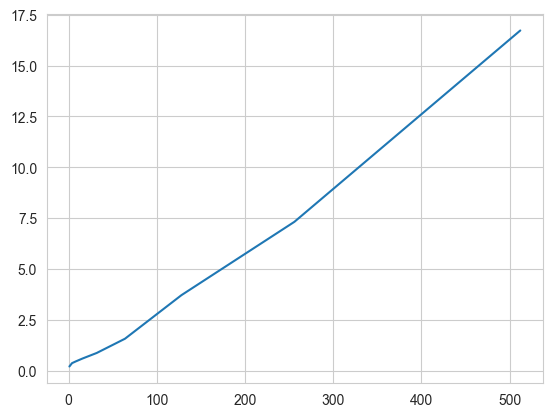

In [21]:
import seaborn as sns

sns.set_style('whitegrid')

sns.lineplot(
    x=[2**i for i in range(b)]*2,
    y=cpu_times+mps_times,
    hue=['cpu']*b + ['mps']*b
)

---

In [ ]:
cpu_times

In [ ]:
mps_times

In [22]:
import numpy
(numpy.array(cpu_times) - numpy.array(mps_times))/numpy.array(cpu_times)

array([ 0.62337845,  0.74163002,  0.83500057, -0.07375961,  0.89656962,
        0.90041402,  0.91912462,  0.56580572,  0.9211546 , -3.83482451])